### MSEplots functions --- adding ensembles of entrainment and detrainment, internal-gravity  waves
---keyword arguments for the ensemble size, and h0 range <br>
fixed: "h4ent = mse" would replace mse as doing h4ent += h0offset, rewriting this part 

(12/05/2018)<br>
---adding s,h,hs overlay, entrainment xaxis <br>
---adding temperature dependence of latent heat Lv and Lice <br>
---adding Z array as an input for "g*z" correction <br> 
---setting axes for detrainment bars, fixed limitation <br>

(01/11/2019) <br>
---defining the first EL for detrainment histogram rather than EL_max to avoid "missing" histogarms on special conditions 

(02/04/2019) <br>
---adding entropy keyword: Raymond and Blyth, 1992 <br>
(Raymond 2013, Sources and sinks of entropy in the atmosphere
 Schubert et al., 2018 Heat and Moisture Budget Analysis with an Improved Form of Moist Thermodynamics: They have different equations for defined entropy, resulting wierd values. Need to be verified someday...)  

<br>
Last Date: 02/04/2019

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import metpy.calc as mpcalc
from metpy.units import units
from metpy.constants import Cp_d,Cp_v,Lv,Rd,g,Rv,Cv_d,Cv_v

In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin() # find minimum
    return (idx)

In [65]:
def thermo_plots(pressure,temperature,mixing_ratio):
    """"
    plots for vertical profiles of temperature, dewpoint, mixing ratio and relative humidity.
    
    Parameters
    ----------
    pressure : array-like
            Atmospheric pressure profile (surface to TOA)
    temperature: array-like
            Atmospheric temperature profile (surface to TOA)
    dewpoint: array-like
            Atmospheric dewpoint profile (surface to TOA)    
    Returns
    -------
    """
    p = pressure*units('mbar')
    q = mixing_ratio*units('kilogram/kilogram')
    T = temperature*units('degC')
    
    Td = mpcalc.dewpoint_from_specific_humidity(q,T,p) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]) # parcel
    
    plt.figure(figsize = (12,5))
    
    lev = find_nearest(p.magnitude,100);
    plt.subplot(1,3,1)
    plt.plot(T[:lev],p[:lev],'-ob')
    plt.plot(Td[:lev],p[:lev],'-og')
    plt.plot(Tp[:lev],p[:lev],'-or')
    plt.xlabel('Temperature [C]',fontsize=12)
    plt.ylabel('Pressure [hpa]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.legend(['Temp','Temp_Dew','Temp_Parcel'],loc=1)
    plt.grid()
    
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    # Relative humidity
    RH = q/qs*100 # Relative humidity

    plt.subplot(1,3,2)
    plt.plot(q[:lev],p[:lev],'-og')
    plt.xlabel('Mixing ratio [kg/kg]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid()

    plt.subplot(1,3,3)
    plt.plot(RH[:lev],p[:lev],'-og')
    plt.xlabel('Relative humiduty [%]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid()
    
    plt.tight_layout()
    return (plt)

def theta_plots(pressure,temperature,mixing_ratio):
    """
    plots for vertical profiles of potential temperature, equivalent potential temperature, 
    and saturated equivalent potential temperature
    """
    p = pressure*units('mbar')
    T = temperature*units('degC')
    q = mixing_ratio*units('kilogram/kilogram')
    
    lev = find_nearest(p.magnitude,100)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    theta = mpcalc.potential_temperature(p,T)
    theta_e = mpcalc.equivalent_potential_temperature(p,T,Td)
    theta_es = mpcalc.equivalent_potential_temperature(p,T,T)
       
    plt.figure(figsize=(7,7))
    plt.plot(theta[:lev],p[:lev],'-ok')
    plt.plot(theta_e[:lev],p[:lev],'-ob')
    plt.plot(theta_es[:lev],p[:lev],'-or')
    plt.xlabel('Temperature [K]',fontsize=12)
    plt.ylabel('Pressure [hpa]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.legend(['$\\theta$','$\\theta_e$','$\\theta_{es}$'],loc=1)
    plt.grid()
    return (plt)

def msed_plots(pressure,temperature,mixing_ratio,altitude,h0_std=2000,ensemble_size=20,ent_rate=np.arange(0,2,0.05),
               entrain=False):
    """
    plotting the summarized static energy diagram with annotations and thermodynamic parameters
    """
    p  = pressure*units('mbar')
    T  = temperature*units('degC')
    q  = mixing_ratio*units('kilogram/kilogram')
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC') # parcel profile
    
    # Altitude based on the hydrostatic eq.
    if len(altitude) == len(pressure): # (1) altitudes for whole levels
        altitude = altitude*units('meter')
    elif len(altitude) == 1: # (2) known altitude where the soundings was launched
        z_surf = altitude.copy()*units('meter'); # given altitude
        altitude = np.zeros((np.size(T)))*units('meter') 
        for i in range(np.size(T)):
            altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) + z_surf # Hypsometric Eq. for height
    else: 
        print('***WARNING***: the altitude at the surface is assumed 0 meter, and altitudes are derived based on the hypsometirc equation')
        altitude = np.zeros((np.size(T)))*units('meter') # surface is 0 meter
        for i in range(np.size(T)):
            altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) # Hypsometric Eq. for height
            
    # Static energy calculations   
    mse = mpcalc.moist_static_energy(altitude,T,q)
    mse_s = mpcalc.moist_static_energy(altitude,T,qs)
    dse = mpcalc.dry_static_energy(altitude,T)

    # Water vapor calculations
    p_PWtop = max(200*units.mbar, min(p) + 1*units.mbar) # integrating until 200mb 
    cwv = mpcalc.precipitable_water(Td,p,top=p_PWtop) # column water vapor [mm]
    cwvs = mpcalc.precipitable_water(T,p,top=p_PWtop) # saturated column water vapor [mm]
    crh = (cwv/cwvs)*100. # column relative humidity [%]

    #================================================
    # plotting MSE vertical profiles
    fig = plt.figure(figsize=[12,8])
    ax = fig.add_axes([0.1,0.1,0.6,0.8])
    ax.plot(dse,p,'-k',linewidth=2)
    ax.plot(mse,p,'-b',linewidth=2)
    ax.plot(mse_s,p,'-r',linewidth=2)
    
    # mse based on different percentages of relative humidity
    qr = np.zeros((9,np.size(qs)))*units('kilogram/kilogram'); mse_r = qr*units('joule/kilogram')# container
    for i in range(9):
        qr[i,:] = qs*0.1*(i+1)
        mse_r[i,:] = mpcalc.moist_static_energy(altitude,T,qr[i,:])

    for i in range(9):
        ax.plot(mse_r[i,:],p[:],'-',color='grey',linewidth=0.7)
        ax.text(mse_r[i,3].magnitude/1000-1,p[3].magnitude,str((i+1)*10))
                
    # drawing LCL and LFC levels
    [lcl_pressure, lcl_temperature] = mpcalc.lcl(p[0], T[0], Td[0])
    lcl_idx = np.argmin(np.abs(p.magnitude - lcl_pressure.magnitude))
    
    [lfc_pressure, lfc_temperature] = mpcalc.lfc(p,T,Td)
    lfc_idx = np.argmin(np.abs(p.magnitude - lfc_pressure.magnitude))
    
    # conserved mse of air parcel arising from 1000 hpa    
    mse_p = np.squeeze(np.ones((1,np.size(T)))*mse[0].magnitude)
    
    # illustration of CAPE
    el_pressure,el_temperature = mpcalc.el(p,T,Td) # equilibrium level
    el_idx = np.argmin(np.abs(p.magnitude - el_pressure.magnitude))
    ELps = [el_pressure.magnitude] # Initialize an array of EL pressures for detrainment profile
    
    [CAPE,CIN] = mpcalc.cape_cin(p[:el_idx],T[:el_idx],Td[:el_idx],Tp[:el_idx])
    
    plt.plot(mse_p,p,color='green',linewidth=2)
    ax.fill_betweenx(p[lcl_idx:el_idx+1],mse_p[lcl_idx:el_idx+1],mse_s[lcl_idx:el_idx+1],interpolate=True
                    ,color='green',alpha='0.3')

    ax.fill_betweenx(p,dse,mse,color='deepskyblue',alpha='0.5')
    ax.set_xlabel('Specific static energies: s, h, hs [kJ kg$^{-1}$]',fontsize=14)
    ax.set_ylabel('Pressure [hPa]',fontsize=14)
    ax.set_xticks([280,300,320,340,360,380])
    ax.set_xlim([280,390])
    ax.set_ylim(1030,120)
    
    if entrain is True:
    # Depict Entraining parcels
    # Parcel mass solves dM/dz = eps*M, solution is M = exp(eps*Z)
    # M=1 at ground without loss of generality
            
    # Distribution of surface parcel h offsets
        H0STDEV = h0_std # J/kg
        h0offsets = np.sort(np.random.normal(0, H0STDEV, ensemble_size))*units('joule/kilogram')
        # Distribution of entrainment rates 
        entrainment_rates = ent_rate /(units('km'))
        
        for h0offset in h0offsets:
            
            h4ent = mse.copy(); h4ent[0] += h0offset;
            
            for eps in entrainment_rates: 
                
                M = np.exp(eps * (altitude-altitude[0])).to('dimensionless')
                # dM is the mass contribution at each level, with 1 at the origin level. 
                M[0] = 0
                dM = np.gradient(M)
                # parcel mass is a sum of all the dM's at each level
                # conserved linearly-mixed variables like h are weighted averages
                if eps.magnitude == 0.0:
                    hent = np.ones(len(h4ent))*h4ent[0] # no mixing 
                else:
                    hent = np.cumsum(dM*h4ent) / np.cumsum(dM)
                # Boolean for positive buoyancy, and its topmost altitude (index) where curve is clippes
                posboy  = (hent > mse_s); posboy[0] = True  # so there is always a detrainment level
                
                # defining the first EL by posboy as the detrainment layer, swiching from positive buoyancy to
                # negative buoyancy (0 to 1) and skipping the surface
                ELindex_ent = 0
                for idx in range(len(posboy)-1):
                    if posboy[idx+1] == 0 and posboy[idx] == 1 and idx > 0: 
                        ELindex_ent = idx;break
                        
                # Plot the curve        
                plt.plot( hent[0:ELindex_ent+2], p[0:ELindex_ent+2], linewidth=0.6, color='g')
                #plt.plot( hent[0:], p[0:], linewidth=0.6, color='g')
                # Keep a list for a histogram plot (detrainment profile)  
                if p[ELindex_ent].magnitude < lfc_pressure.magnitude: # buoyant parcels only
                    ELps.append( p[ELindex_ent].magnitude )
                
        # Plot a crude histogram of parcel detrainment levels
        NBINS = 20
        pbins = np.linspace(1000,150,num=NBINS) # pbins for detrainment levels
        hist = np.zeros((len(pbins)-1))
        for x in ELps:
            for i in range(len(pbins)-1):
                if (x < pbins[i]) & (x >= pbins[i+1]):
                    hist[i] += 1;break
                    
        det_per = hist/sum(hist)*100; # percentages of detrainment ensumbles at levels
        
        ax2 = fig.add_axes([0.705,0.1,0.1,0.8],facecolor=None)
        ax2.barh( pbins[1:], det_per, color='lightgrey',edgecolor='k',height=15*(20/NBINS))
        ax2.set_xlim([0,100])
        ax2.set_xticks([0,20,40,60,80,100])
        ax2.set_ylim([1030,120])
        ax2.set_xlabel('Detrainment [%]')
        ax2.grid()
        ax2.set_zorder(2)

        ax.plot( [400,400], [1100,0])
        ax.annotate('Detrainment', xy=(362,320), color='dimgrey')
        ax.annotate('ensemble: ' + str(ensemble_size*len(entrainment_rates)), xy=(364, 340), color='dimgrey')
        ax.annotate('Detrainment', xy=(362,380), color='dimgrey')
        ax.annotate(' scale: 0 - 2 km', xy=(365,400), color='dimgrey')
    
        # Overplots on the mess: undilute parcel and CAPE, etc. 
        ax.plot( (1,1)*mse[0], (1,0)*(p[0]), color='g',linewidth=2)

        # Replot the sounding on top of all that mess
        ax.plot(mse_s , p, color='r', linewidth=1.5) 
        ax.plot(mse , p, color='b', linewidth=1.5) 

        # label LCL and LCF
        ax.plot((mse_s[lcl_idx]+(-2000,2000)*units('joule/kilogram')), lcl_pressure+(0,0)*units('mbar') ,color='orange',linewidth=3)
        ax.plot((mse_s[lfc_idx]+(-2000,2000)*units('joule/kilogram')), lfc_pressure+(0,0)*units('mbar') , color='magenta',linewidth=3)
  
    
    ### Internal waves (100m adiabatic displacements, assumed adiabatic: conserves s, sv, h). 
    #dZ = 100 *mpunits.units.meter
    dp = 1000*units.pascal
    
    # depict displacements at sounding levels nearest these target levels
    targetlevels = [900,800,700,600,500,400,300,200]*units.hPa
    for ilev in targetlevels:
        idx = np.argmin(np.abs(p - ilev))

        # dp: hydrostatic
        rho = (p[idx])/Rd/(T[idx])
        dZ = -dp/rho/g

        # dT: Dry lapse rate dT/dz_dry is -g/Cp
        dT = (-g/Cp_d *dZ).to('kelvin')    
        Tdisp = T[idx].to('kelvin') + dT

        # dhsat
        dqs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Tdisp) ,p[idx]+dp) - qs[idx]
        dhs = g*dZ + Cp_d*dT + Lv*dqs

        # Whiskers on the data plots
        ax.plot( (mse_s[idx]+dhs*(-1,1)), p[idx]+dp*(-1,1), linewidth=3, color='r')  
        ax.plot( (dse[idx]    *( 1,1)), p[idx]+dp*(-1,1), linewidth=3, color='k')  
        ax.plot( (mse[idx]    *( 1,1)), p[idx]+dp*(-1,1), linewidth=3, color='b')  

        # annotation to explain it 
        if ilev == 400*ilev.units:
            ax.plot(360*mse_s.units +dhs*(-1,1)/1000, 440*units('mbar')
                     +dp*(-1,1), linewidth=3, color='r')  
            ax.annotate('+/- 10mb', xy=(362,440), fontsize=8)
            ax.annotate(' adiabatic displacement', xy=(362,460), fontsize=8)
    
    # Plot a crude histogram of parcel detrainment levels
    # Text parts
    ax.text(290,pressure[3],'RH (%)',fontsize=11,color='k')
    ax.text(285,200,'CAPE = '+str(np.around(CAPE.magnitude,decimals=2))+' [J/kg]',fontsize=12,color='green')
    ax.text(285,250,'CIN = '+str(np.around(CIN.magnitude,decimals=2))+' [J/kg]',fontsize=12,color='green')
    ax.text(285,300,'LCL = '+str(np.around(lcl_pressure.magnitude,decimals=2))+' [hpa]',fontsize=12,color='darkorange')
    ax.text(285,350,'LFC = '+str(np.around(lfc_pressure.magnitude,decimals=2))+' [hpa]',fontsize=12,color='magenta')
    ax.text(285,400,'CWV = '+str(np.around(cwv.magnitude,decimals=2))+' [mm]',fontsize=12,color='deepskyblue')
    ax.text(285,450,'CRH = '+str(np.around(crh.magnitude,decimals=2))+' [%]',fontsize=12,color='blue')
    ax.legend(['DSE','MSE','SMSE'],fontsize=12,loc=1)
    
    ax.set_zorder(3)
    
    return (ax)

def add_curves_Wyoming(datetime,station,linewidth=1.0,LH_Tdepend=False):
    """
    overlaying new curves of multiple soundings from Wyoming datasets
    date: using datetime module. ex. datetime(2018,06,06) 
    station: station name. ex. 'MFL' Miami, Florida
    """
    from siphon.simplewebservice.wyoming import WyomingUpperAir

    date = datetime
    station = station
    df = WyomingUpperAir.request_data(date, station)
    pressure = df['pressure'].values
    Temp = df['temperature'].values
    Temp_dew = df['dewpoint'].values
    altitude = df['height'].values
    q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Temp_dew*units('degC')),pressure*units('mbar'))
    q = mpcalc.specific_humidity_from_mixing_ratio(q)
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Temp*units('degC')),pressure*units('mbar'))
    
    # specific energies
    if LH_Tdepend == False:
        mse = mpcalc.moist_static_energy(altitude*units('meter'),Temp*units('degC'),q)
        mse_s = mpcalc.moist_static_energy(altitude*units('meter'),Temp*units('degC'),qs)
        dse = mpcalc.dry_static_energy(altitude*units('meter'),Temp*units('degC'))
    else:
        # A short course in cloud physics, Roger and Yau (1989)
        Lvt = (2500.8 - 2.36*T.magnitude + 0.0016*T.magnitude**2 - 
              0.00006*T.magnitude**3)*units('joule/gram') # latent heat of evaporation
        #Lf = 2834.1 - 0.29*T - 0.004*T**2                  # latent heat of fusion
        
        mse = Cp_d*T + g*altitude + Lvt*q
        mse_s = Cp_d*T + g*altitude + Lvt*qs
        dse = mpcalc.dry_static_energy(altitude,T)
        
    # adding curves on the main axes
    ax.plot(dse.magnitude, pressure, 'k', linewidth=linewidth)
    ax.plot(mse.magnitude, pressure, 'b', linewidth=linewidth)
    ax.plot(mse_s.magnitude, pressure, 'r', linewidth=linewidth)

def add_curves(pressure,temperature,mixing_ratio,altitude,linewidth=1.0,LH_Tdepend=False):
    """
    overlaying new curves of multiple soundings from profiles
    """
    p  = pressure*units('mbar')
    T  = temperature*units('degC')
    q  = mixing_ratio*units('kilogram/kilogram')
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC') # parcel profile

    # Altitude based on the hydrostatic eq.
    if len(altitude) == len(pressure): # (1) altitudes for whole levels
        altitude = altitude*units('meter')
    elif len(altitude) == 1: # (2) known altitude where the soundings was launched
        z_surf = altitude.copy()*units('meter'); # given altitude
        altitude = np.zeros((np.size(T)))*units('meter') 
        for i in range(np.size(T)):
            altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) + z_surf # Hypsometric Eq. for height
    else: 
        print('***WARNING***: the altitude at the surface is assumed 0 meter, and altitudes are derived based on the hypsometirc equation')
        altitude = np.zeros((np.size(T)))*units('meter') # surface is 0 meter
        for i in range(np.size(T)):
            altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) # Hypsometric Eq. for height
    
    # specific energies 
    if LH_Tdepend == False:
        mse = mpcalc.moist_static_energy(altitude,T,q)
        mse_s = mpcalc.moist_static_energy(altitude,T,qs)
        dse = mpcalc.dry_static_energy(altitude,T)
    else:
        # A short course in cloud physics, Roger and Yau (1989)
        Lvt = (2500.8 - 2.36*T.magnitude + 0.0016*T.magnitude**2 - 
              0.00006*T.magnitude**3)*units('joule/gram') # latent heat of evaporation
        #Lf = 2834.1 - 0.29*T - 0.004*T**2                  # latent heat of fusion
        
        mse = Cp_d*T + g*altitude + Lvt*q
        mse_s = Cp_d*T + g*altitude + Lvt*qs
        dse = mpcalc.dry_static_energy(altitude,T)
        
    ax.plot(dse, p, '--k', linewidth=linewidth)
    ax.plot(mse, p, '--b', linewidth=linewidth)
    ax.plot(mse_s, p, '--r', linewidth=linewidth)

def add_RCEREF(cooling=-1.3,heatflux=116):
    ### Energy is area, draw reference boxes. 
    RCEloc = 260
    ax.set_xlim([250,390])

    ax.plot([RCEloc,RCEloc],[0,1100], linewidth=0.5) ### thin reference line
    ax.annotate('daily RCE', xy=(RCEloc,1045), horizontalalignment='center')

    #### Radiative cooling reference
    ax.fill([RCEloc  , RCEloc -1.3, RCEloc -1.3, RCEloc, RCEloc ],             
            [1000 , 1000    , 200     , 200, 1000],             
            linewidth=1, color='c', alpha=0.9)

    ax.annotate(' cooling'+ str(cooling) + '$K/d$',  xy=(RCEloc-5, 300), color='c')

    #### Surface flux reference
    ax.fill([RCEloc  , RCEloc +11, RCEloc +11, RCEloc, RCEloc ],             
            [1000 , 1000   , 910    , 910, 1000],             
            linewidth=1, color='orange', alpha=0.5)

    ax.annotate(' heat flux', xy=(RCEloc,890), color='orange')
    ax.annotate(str(heatflux) + '$W m^{-2}$', xy=(RCEloc,940))
    
def add_entropy(pressure,temperature,mixing_ratio,ds=100,linewidth=1.0):
    "add entropy curves and rescale values to fit in by 0.5*entropy + ds"
    p  = pressure*units('mbar')
    T  = temperature*units('degC')
    q  = mixing_ratio*units('kilogram/kilogram')
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC') # parcel profile

    # Reference: 
    #Schubert, W. H., Ciesielski, P. E., & Johnson, R. H. (2018). Heat and Moisture Budget Analysis with an Improved Form of Moist Thermodynamics
    
    Tref = 273.15*units('kelvin')            # reference temperature (C to K conversion)
    pref = 1000.0*units('mbar')              # reference pressure (mb)
    Lref = Lv                                # vaporization heat  # liquid water heat capacity
    Cl  =  4218*units('joule/kilogram/kelvin')      # liquid water heat capacity
    eref = 6.106*units('mbar')               # sat p at Tref (mb)

    L = Lref - (Cl - Cp_v)*T;   # L at temperature T

    # specific entropy [joule/(kg*K)]
    # sd : specific entropy of dry air
    # sm1 : specific entropy of airborne mositure in state 1 (water vapor)
    # sm2 : specific entropy of airborne mositure in state 2 (saturated water vapor)

    def entropy(T,q,p,ds=100):
        qtot = q;
        qsat = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
        qv = np.minimum(qtot, qsat);       # IN CASE QTOT > QSAT
        e = qv*p/(Rd/Rv +qv);
        Tt = T.magnitude*units('kelvin') + Tref
    
        if sum(qtot) == 0:
            entropy = (( Cp_d + qtot*Cl )*np.log( Tt/Tref ) - Rd*np.log( (p-e)/pref )).to('joule/kilogram/kelvin')
        else:
            entropy = (( Cp_d + qtot*Cl )*np.log( Tt/Tref ) - Rd*np.log( (p-e)/pref ) + 
                       L*qv/( Tt ) - qv*Rv*np.log( qv/qsat )).to('joule/kilogram/kelvin');
        return entropy
    
    sd = entropy(T,q*0,p)
    sm1 = entropy(T,q,p)
    sm2 = entropy(T,qs,p)

    ax.plot(sd.magnitude*0.5+ds,p,'--k')
    ax.plot(sm1.magnitude*0.5+ds,p,'--b')
    ax.plot(sm2.magnitude*0.5+ds,p,'--r')

In [63]:
from siphon.simplewebservice.wyoming import WyomingUpperAir
# reading data prociding vertical profiles of T, Td, pressure and height
date = datetime(2018, 11, 30, 12)
station = 'SKBQ'

df = WyomingUpperAir.request_data(date, station)
pressure = df['pressure'].values 
Temp = df['temperature'].values 
Temp_dew = df['dewpoint'].values 
altitude = df['height'].values

from metpy.calc.thermo import *
from metpy.units import units
q = mixing_ratio(saturation_vapor_pressure(Temp_dew*units.degC),pressure*units.mbar)
q = specific_humidity_from_mixing_ratio(q)

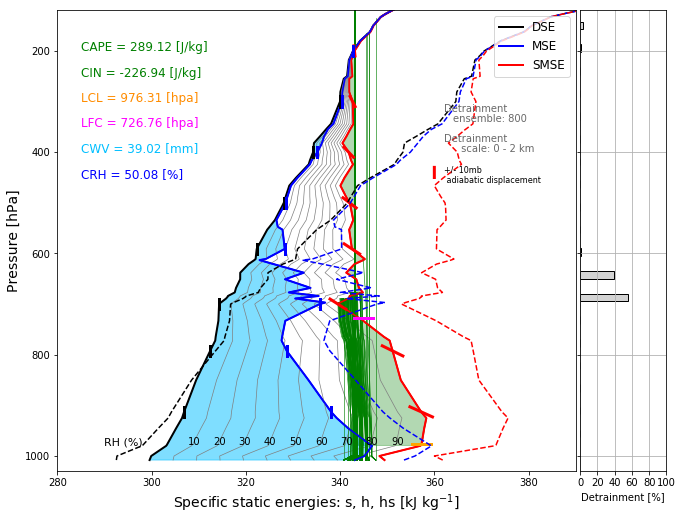

In [66]:
ax = msed_plots(pressure,Temp,q,altitude,ent_rate=np.arange(0,2,0.05),entrain=True) # altitude included
add_entropy(pressure,Temp,q,ds=250)

In [20]:
q

<Quantity([1.75164446e-02 1.64706505e-02 1.65016550e-02 1.60218094e-02
 1.53006078e-02 1.48062855e-02 1.44173942e-02 1.32362683e-02
 1.21296140e-02 1.20837069e-02 1.17750447e-02 1.13988947e-02
 9.74348850e-03 9.38078943e-03 9.31730007e-03 9.27668023e-03
 7.28263336e-03 6.30911717e-03 5.60951561e-03 5.13049309e-03
 4.02944386e-03 6.43094957e-03 4.88780764e-03 4.42619200e-03
 3.77977531e-03 4.66359844e-03 4.74509299e-03 3.28715842e-03
 2.73518893e-03 2.54628946e-03 1.43391277e-03 3.63746981e-03
 1.83085896e-03 2.24215559e-03 2.66097066e-03 1.90110104e-03
 2.32345503e-03 2.41717868e-03 1.72060469e-03 1.69483984e-03
 1.91154126e-03 2.79427498e-03 2.79484984e-03 2.53366497e-03
 1.50735189e-03 1.30458176e-03 1.01090280e-03 3.82497866e-04
 4.65886807e-04 4.45008219e-04 2.74491902e-04 5.77372482e-04
 2.26146104e-04 1.16314949e-04 2.80453461e-04 5.73310254e-04
 2.33104902e-04 3.95626815e-04 2.25997510e-04 1.76013132e-04
 9.42534533e-05 4.84926484e-05 5.24450721e-05 6.30345168e-05
 2.45425230e-04 2.35919761e-04 1.59285253e-04 1.12765677e-04
 1.04429851e-04 8.84019874e-05 9.55806770e-05 9.80027751e-05
 6.33688780e-05 4.12262311e-05 2.92999022e-05 1.55742717e-05
 1.36569130e-05 1.63416566e-05 2.02496310e-05 8.52592738e-06
 6.83412788e-06 6.30632545e-06 6.37524730e-06 7.41521463e-06
 7.04937000e-06 5.66204742e-06 4.45316419e-06 2.79001684e-06
 2.52325432e-06 2.47044579e-06 2.47131757e-06 2.58391044e-06
 2.35919068e-06 2.38577996e-06 2.46584524e-06 2.63698720e-06
 2.72457231e-06 2.81874448e-06 2.99528937e-06 2.98015763e-06
 3.25435171e-06 3.72471345e-06 4.04863165e-06 3.91633453e-06
 4.10949886e-06 4.31452862e-06 4.91698369e-06 5.61524526e-06
 6.29417057e-06 7.09381212e-06 7.18446826e-06 7.49579664e-06
 8.19904741e-06 1.04612259e-05 1.26772916e-05 1.58716485e-05
 1.74686279e-05 1.79585811e-05 1.94121668e-05 2.13815697e-05
 2.55053668e-05 2.80851941e-05 3.08855061e-05 3.24078525e-05
 3.58934694e-05 4.53315179e-05 4.65388103e-05 4.90619442e-05
 6.01487165e-05 7.28064216e-05 8.00899727e-05], 'dimensionless')>

In [90]:
esat = 6.1094*np.exp(17.625*Temp/(Temp+243.04))*units('mbar')
esat[:5]

<Quantity([23.91857788 23.62490842 20.85768487 18.61483798 16.586779  ], 'millibar')>

In [ ]:
a=273.15*units('degC')
b=20*units('degC')
a/b*units('mbar')
T_ref = 273.15*units('kelvin')
b.to('kelvin')/T_ref

In [ ]:
Rv.to('joule/kilogram/kelvin')

In [ ]:
(Lv*q/T_ref).to('joule/kilogram/kelvin')

In [103]:
np.log(0.018/0.005)

1.2809338454620642

In [104]:
Temp[0]

20.4